In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np
from shapely.ops import nearest_points
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.geometry import Point, LineString
import src.shapes as shapes
import src.api as api
from shapely.ops import linemerge

In [2]:
refresh_token = "AMf-vBxxw5qPbH_3R4W6BM_8CFhMZTQPbhnG-6VHefeNOvR4UNYTs9DEmNQ7_U38n9Xc2XXUpRkUeBvFMzu9dplgb_CRgRiwx5yEX9lxzvSv1ryKe18CDTOf437RZFR7dv_mre80SYAFd0myoXV6r5TTLHQDW9X73hwea3X5cVbnlpt3Tdxl_nUSzV2uWpG0JVELOr5AUjzSFcyefHyyWSv7kqC1cVWfnXWcQ1oF22VcOBVcUaGF-7Yk33rw1yclpDa0PfFtYjzOP-PxDn4LD1xxF1rsS6n-sqJQZ-3jssAdsFMz0M9eDIwh648tbsP_l5s45TFs2VEr2RsUAMvVuDgn7BLo0RBIq-HJNWJDvmTIsE98thkFHzN713cd3QbfNquuiRosyuTXOo1el3QxJ2QR2mgNqjQSyGWU8HosYvy0jfV25SYK0jrnkBQPYLA09CPThEZ5-FCI"
access_token = api.get_access_token(refresh_token)

In [42]:
class GTFS_shape_processor:
    """
    A class to process GTFS shapes and stop data, compute distances, 
    and create segments between stops along routes.
    """
    
    def __init__(self, GTFS_zip_file, crs=4326, target_crs=2263):
        """
        Initialize the processor with GTFS zip file and coordinate reference systems.
        
        Parameters:
        - GTFS_zip_file: Path to the GTFS zip file.
        - crs: The coordinate reference system of the input data (default EPSG:4326).
        - target_crs: The target CRS for output (default EPSG:2263).
        """
        self.GTFS_dict = api.parse_zipped_gtfs(GTFS_zip_file)
        self.crs = crs
        self.target_crs = target_crs

    def _prep_shapes(self, shapes):
        """
        Prepare shapes by grouping them into LineStrings based on shape_id.
        
        Parameters:
        - shapes: The 'shapes.txt' data from the GTFS file.

        Returns:
        - A GeoDataFrame with LineStrings for each shape_id.
        """
        gdf = shapes.groupby('shape_id').apply(
            lambda x: LineString(zip(x['shape_pt_lon'], x['shape_pt_lat'])), include_groups =False
        ).reset_index()

        gdf = gdf.rename(columns={0: 'geometry'})
        gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
        gdf = gdf.set_crs(epsg=self.crs)

        return gdf

    def _prep_GTFS(self):
        """
        Prepare the merged stop and shape data from the GTFS files.

        Returns:
        - merged_stops: A GeoDataFrame of stops with geometry.
        - shape_lines: A GeoDataFrame of shape lines.
        """
        stop_times = self.GTFS_dict['stop_times.txt']
        shapes = self.GTFS_dict['shapes.txt']
        stops = self.GTFS_dict['stops.txt']
        trips = self.GTFS_dict['trips.txt']

        merged_stops = stop_times.merge(trips).drop_duplicates(["stop_id", "shape_id"]).merge(stops)
        merged_stops['geometry'] = merged_stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
        merged_stops = gpd.GeoDataFrame(merged_stops, geometry='geometry').set_crs(self.crs).to_crs(self.target_crs)

        shape_lines = self._prep_shapes(shapes).to_crs(self.target_crs).set_index("shape_id")

        return merged_stops, shape_lines

    def _get_shape_position(self, point_location, shape_id, shape_lines):
        """
        Compute the distance from a stop point to the nearest location on a shape line.

        Parameters:
        - point_location: A shapely Point object representing the stop location.
        - shape_id: The shape_id corresponding to the route.
        - shape_lines: A GeoDataFrame containing LineStrings for each shape_id.

        Returns:
        - A dictionary containing the distance to the line and the projected position along the line.
        """
        out = {}
        try:
            line = shape_lines.loc[shape_id].iloc[0]
            out["distance_to_line"] = point_location.distance(line)
            out["projected_position"] = line.project(point_location)
        except KeyError:
            out["distance_to_line"] = None
            out["projected_position"] = None

        return out
    
    def _create_segment(self, shape_lines, shape_id, distance1, distance2):
        """
        Create a segment from a LineString defined by two distances along the line.

        Parameters:
        - shape_lines: A GeoDataFrame containing LineStrings for each shape_id.
        - shape_id: The shape_id corresponding to the route.
        - distance1: First distance along the LineString.
        - distance2: Second distance along the LineString.

        Returns:
        - A LineString representing the segment between distance1 and distance2, or None if an error occurs.
        """
        try:
            line = shape_lines.loc[shape_id].iloc[0]
            start_point = line.interpolate(distance1)
            end_point = line.interpolate(distance2)
            return LineString([start_point, end_point])
        except Exception as e:
            return None

    def process_shapes(self, out_path=None):
        """
        Process the GTFS shapes and stop data, computing the segment between consecutive stops.

        Parameters:
        - out_path: If specified, saves the output GeoDataFrame to a file. Otherwise, returns the GeoDataFrame.

        Returns:
        - A GeoDataFrame containing segments between consecutive stops, or writes to a file if out_path is specified.
        """
        merged_stops, shape_lines = self._prep_GTFS()
        
        dists = merged_stops.apply(lambda x: self._get_shape_position(x.geometry, x.shape_id, shape_lines), axis=1)
        merged_stops = merged_stops.join(pd.json_normalize(dists))
        merged_stops["prev_projected_position"] = merged_stops.groupby("shape_id")["projected_position"].shift(1)
        merged_stops["prev_stop_id"] = merged_stops.groupby("shape_id")["stop_id"].shift(1)
        merged_stops["prev_stop_name"] = merged_stops.groupby("shape_id")["stop_name"].shift(1)

        merged_stops["segment_linestring"] = merged_stops.apply(
            lambda x: self._create_segment(shape_lines, x.shape_id, x.prev_projected_position, x.projected_position), 
            axis=1
        )
        
        merged_stops = gpd.GeoDataFrame(merged_stops.drop("geometry", axis=1), geometry="segment_linestring", crs=self.target_crs)

        out_cols = ["trip_id", "shape_id", "stop_id", "stop_name", "prev_stop_id", "prev_stop_name", "projected_position", "prev_projected_position", "geometry"]

        if out_path is not None:
            merged_stops[out_cols].to_file(out_path)
            print(f"Wrote segments to {out_path}")
        else:
            return merged_stops[out_cols]

In [43]:
shape_processor = GTFS_shape_processor("https://transitfeeds.com/p/mta/82/20230919/download", 4326, 2263)

Files in the zip: ['agency.txt', 'calendar.txt', 'calendar_dates.txt', 'routes.txt', 'shapes.txt', 'stops.txt', 'stop_times.txt', 'trips.txt']
Data from agency.txt:
Data from calendar.txt:
Data from calendar_dates.txt:
Data from routes.txt:
Data from shapes.txt:
Data from stops.txt:
Data from stop_times.txt:
Data from trips.txt:


In [45]:
shape_processor.process_shapes()

/home/canyon/.local/share/virtualenvs/TOP-Sprint-lAvM2-mU/lib/python3.9/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


,trip_id,shape_id,stop_id,stop_name,prev_stop_id,prev_stop_name,projected_position,prev_projected_position,segment_linestring
0,MQ_O3-Weekday-036000_M9_51,M090014,405396,1 AV/E 27 ST,NaN,NaN,0.03,NaN,None
1,MQ_O3-Weekday-036000_M9_51,M090014,402048,E 29 ST/1 AV,405396.00,1 AV/E 27 ST,467.31,0.03,"LINESTRING (990755.311 208747.940, 990909.748 ..."
2,MQ_O3-Weekday-036000_M9_51,M090014,402049,E 29 ST/2 AV,402048.00,E 29 ST/1 AV,1096.29,467.31,"LINESTRING (990909.748 209135.647, 990360.379 ..."
3,MQ_O3-Weekday-036000_M9_51,M090014,401832,E 23 ST/2 AV,402049.00,E 29 ST/2 AV,2843.91,1096.29,"LINESTRING (990360.379 209441.937, 989652.478 ..."
4,MQ_O3-Weekday-036000_M9_51,M090014,405390,E 23 ST/1 AV,401832.00,E 23 ST/2 AV,3434.43,2843.91,"LINESTRING (989652.478 208052.528, 990166.419 ..."
...,...,...,...,...,...,...,...,...,...
5721,MQ_D3-Weekday-SDon-091000_M9_57,M110064,401413,10 AV/W 57 ST,401412.00,10 AV/W 55 ST,15997.11,15615.96,"LINESTRING (987206.120 219099.000, 987391.839 ..."
5722,MQ_D3-Weekday-SDon-091000_M9_57,M110064,401414,AMSTERDAM AV/W 59 ST,401413.00,10 AV/W 57 ST,16706.26,15997.11,"LINESTRING (987391.839 219431.835, 987735.718 ..."
5723,MQ_D3-Weekday-SDon-091000_M9_57,M110064,401416,AMSTERDAM AV/W 62 ST,401414.00,AMSTERDAM AV/W 59 ST,17547.13,16706.26,"LINESTRING (987735.718 220052.011, 988141.271 ..."
5724,MQ_D3-Weekday-SDon-091000_M9_57,M110064,401417,AMSTERDAM AV/W 65 ST,401416.00,AMSTERDAM AV/W 62 ST,18252.54,17547.13,"LINESTRING (988141.271 220788.546, 988481.326 ..."


In [4]:
GTFS_dict = api.parse_zipped_gtfs("https://transitfeeds.com/p/mta/82/20230919/download")
GTFS_dict["stop_times.txt"]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,timepoint
0,MQ_O3-Weekday-036000_M9_51,06:00:00,06:00:00,405396,1,0,0,1
1,MQ_O3-Weekday-036000_M9_51,06:00:39,06:00:39,402048,2,0,0,0
2,MQ_O3-Weekday-036000_M9_51,06:01:31,06:01:31,402049,3,0,0,0
3,MQ_O3-Weekday-036000_M9_51,06:03:56,06:03:56,401832,4,0,0,0
4,MQ_O3-Weekday-036000_M9_51,06:04:45,06:04:45,405390,5,0,0,0
...,...,...,...,...,...,...,...,...
1188899,OH_D3-Weekday-SDon-147000_M101_140,25:06:54,25:06:54,402705,49,0,0,0
1188900,OH_D3-Weekday-SDon-147000_M101_140,25:07:39,25:07:39,405181,50,0,0,0
1188901,OH_D3-Weekday-SDon-147000_M101_140,25:08:18,25:08:18,402707,51,0,0,0
1188902,OH_D3-Weekday-SDon-147000_M101_140,25:08:50,25:08:50,450492,52,0,0,0


In [5]:
def create_stop_segments(GTFS_dict, crs = 2263):
    stop_times = GTFS_dict['stop_times.txt']
    shapes = GTFS_dict['shapes.txt']
    stops = GTFS_dict['stops.txt']
    trips = GTFS_dict['trips.txt']

    merged_stops = stop_times.merge(trips).drop_duplicates(["stop_id", "shape_id"]).merge(stops)
    merged_stops['geometry'] = merged_stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
    merged_stops = gpd.GeoDataFrame(merged_stops, geometry='geometry').set_crs(4326).to_crs(2263)

    return shapes, merged_stops

In [9]:
shape_lines = prep_shapes(shapes).to_crs(2263).set_index("shape_id")

In [10]:
shape_lines

,geometry
shape_id,
M010048,"LINESTRING (986918.959 205728.340, 986963.554 ..."
M010049,"LINESTRING (984874.243 201836.053, 984879.509 ..."
M010052,"LINESTRING (1002004.986 238418.702, 1001878.38..."
M010054,"LINESTRING (1002004.986 238418.702, 1001878.38..."
M010055,"LINESTRING (984874.243 201836.053, 984879.509 ..."
...,...
SBS230020,"LINESTRING (991322.725 206258.232, 991331.328 ..."
SBS603238,"LINESTRING (993188.062 231403.666, 993195.493 ..."
SBS603240,"LINESTRING (1021788.290 219946.151, 1021757.22..."


In [10]:
def get_shape_position(point_location, shape_id, shape_lines):
    out = {}
    line = shape_lines.loc[shape_id].iloc[0]
    out["distance_to_line"] = point_location.distance(line)
    out["projected_position"] = line.project(point_location)

    return out

def create_segment(shape_id, distance1, distance2):
    """
    Create a segment from a LineString defined by two distances along the line.
    
    Parameters:
    - line: A shapely LineString object.
    - distance1: First distance along the LineString.
    - distance2: Second distance along the LineString.
    
    Returns:
    - A LineString representing the segment between distance1 and distance2.
    """

    try:
        line = shape_lines.loc[shape_id].iloc[0]
        
        start_point = line.interpolate(distance1)
        end_point = line.interpolate(distance2)
        
        segment = LineString([start_point, end_point])
        
        return segment
    except Exception as e:
        return None

In [11]:
cols = ["route_id", "direction_id", "shape_id", "stop_id", "stop_name", "stop_sequence", "geometry"]
merged_stops_trim = merged_stops[cols]

/home/canyon/.local/share/virtualenvs/TOP-Sprint-lAvM2-mU/lib/python3.9/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [15]:
merged_stops_trim.to_file("manhattan_bus_segments.geojson")

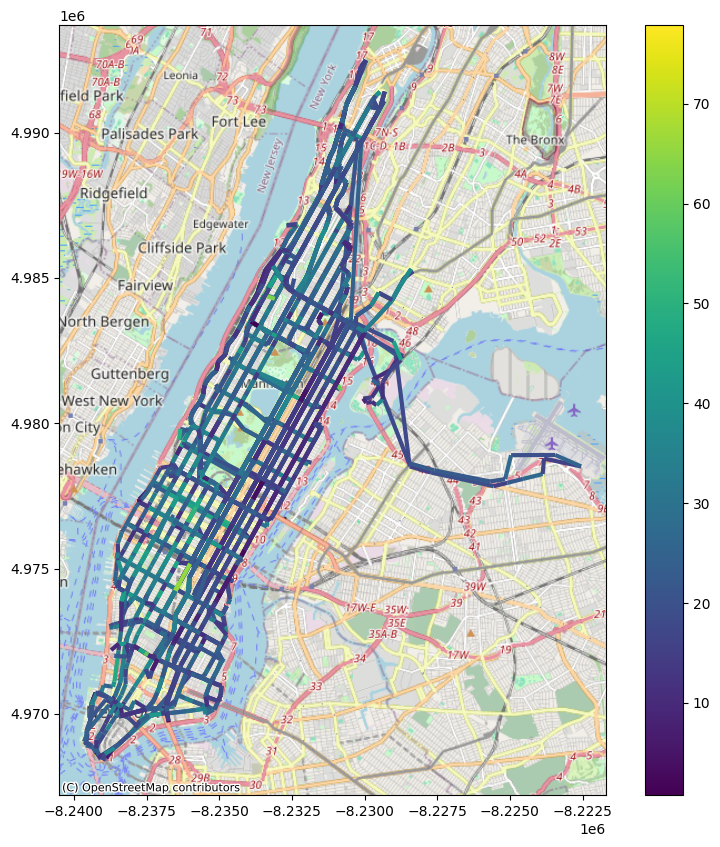

In [16]:
gdf = merged_stops_trim.to_crs(3857)
    
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, linewidth=3, column="distance_to_line", cmap='viridis', legend=True)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)